In [1]:
# -*- coding:utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

import knn

# 1.文件读取

In [2]:
df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv', header=0) # header参数指定标题的行，默认为0.如果没有标题，则使用None

In [3]:
print(df.head())

                                                 url   timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...       731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...       731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...       731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...       731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/       731.0   

    n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0             12.0              219.0          0.663594                1.0   
1              9.0              255.0          0.604743                1.0   
2              9.0              211.0          0.575130                1.0   
3              9.0              531.0          0.503788                1.0   
4             13.0             1072.0          0.415646                1.0   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs  ...  \
0                   0.815385         4.0     

In [4]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

# 2.转化为二分类问题

In [5]:
for i in range(len(df[' shares'])):
    df.loc[i, ' shares'] = 0 if df[' shares'][i] < 1400 else 1

# 3.数据预处理

In [6]:
# 去掉前两列与预测无关的数据
df = df.drop("url", axis=1)
df = df.drop(" timedelta", axis=1)

In [7]:
print(df.head())

    n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0             12.0              219.0          0.663594                1.0   
1              9.0              255.0          0.604743                1.0   
2              9.0              211.0          0.575130                1.0   
3              9.0              531.0          0.503788                1.0   
4             13.0             1072.0          0.415646                1.0   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs  \
0                   0.815385         4.0              2.0        1.0   
1                   0.791946         3.0              1.0        1.0   
2                   0.663866         3.0              1.0        1.0   
3                   0.665635         9.0              0.0        1.0   
4                   0.540890        19.0             19.0       20.0   

    num_videos   average_token_length  ...   min_positive_polarity  \
0          0.0              

# 4.划分训练集与测试集

In [8]:
# 分配训练集和测试集（由于原文件已经按照时间远近进行了排序，所以需要先划分，后打乱）
rate = 0.7 # 7:3
midi = round(len(df) * 0.7)
df1 = df.iloc[:midi, :]
df2 = df.iloc[midi:, :]

# 打乱数据
df1 = df1.sample(len(df1), random_state=0)
df2 = df2.sample(len(df2), random_state=0)

train_X = df1.iloc[:, :-1]
train_y = df1.iloc[:,  -1]
test_X  = df2.iloc[:, :-1]
test_y  = df2.iloc[:,  -1]

# 5. 数据归一化

In [9]:
from sklearn.preprocessing import StandardScaler

### 数据预处理
## 分别对训练集、验证集和测试集进行数据标准化
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X.squeeze())     # 训练集
test_X = scaler.fit_transform(test_X.squeeze())       # 测试集

# 6.训练与测试

In [10]:
# 模型初始化
knn_k = 6
knn_model = knn.knn(knn_k)
# 模型训练
knn_model.fit(train_X, train_y)
# 模型预测
prey = knn_model.predict(test_X)

In [11]:
# 模型评估
TP = 0 # 正例被预测为正例
FN = 0 # 正例被预测为反例
FP = 0 # 反例被预测为正例
TN = 0 # 反例被预测为反例
temp_test_y = test_y.values # 从series转换为 n array
# 统计
for i in range(len(prey)):
    if prey[i] == temp_test_y[i]:
        if prey[i] == 1:
            TP = TP + 1
        else:
            TN = TN + 1
    else:
        if prey[i] == 1:
            FP = FP + 1
        else:
            FN = FN + 1
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1_score = (2 * precision * recall) / (precision + recall)
AUC = roc_auc_score(temp_test_y, prey)

# 记录并打印
result = [
    ['KNN中k值', knn_k],
    ['准确率accuracy', accuracy],
    ['精确率precision', precision],
    ['召回率recall', recall],
    ['F1-score', F1_score],
    ['AUC', AUC]
]
result_out = pd.DataFrame(result)
print(result_out)

              0         1
0        KNN中k值  6.000000
1   准确率accuracy  0.607921
2  精确率precision  0.644102
3     召回率recall  0.479279
4      F1-score  0.549599
5           AUC  0.607694


# 7.K值的取得

当前进度：0.052632
当前进度：0.105263
当前进度：0.157895
当前进度：0.210526
当前进度：0.263158
当前进度：0.315789
当前进度：0.368421
当前进度：0.421053
当前进度：0.473684
当前进度：0.526316
当前进度：0.578947
当前进度：0.631579
当前进度：0.684211
当前进度：0.736842
当前进度：0.789474
当前进度：0.842105
当前进度：0.894737
当前进度：0.947368
当前进度：1.000000


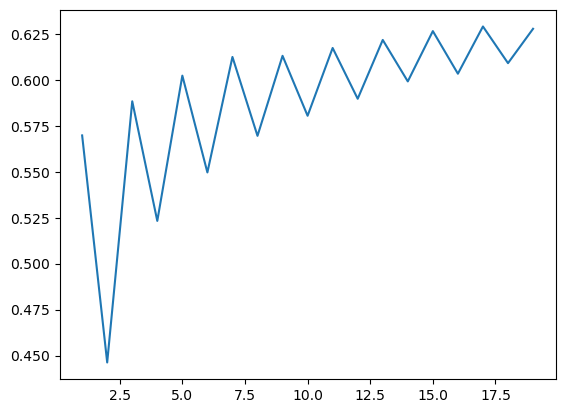

In [12]:
F1_score_group = []
K_range = range(1, 20, 1)
temp_test_y = test_y.values # 从series转换为 n array

for kk in K_range:
    knn_k = kk
    knn_model = knn.knn(knn_k)
    knn_model.fit(train_X, train_y)
    prey = knn_model.predict(test_X)

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    for i in range(len(prey)):
        if prey[i] == temp_test_y[i]:
            if prey[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if prey[i] == 1:
                FP = FP + 1
            else:
                FN = FN + 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = (2 * precision * recall) / (precision + recall)

    print("当前进度：%f" %(kk / len(K_range)))
    F1_score_group.append(F1_score)

plt.plot(K_range, F1_score_group)

# 8.K折交叉验证

In [13]:
import numpy as np

cv = 5 # cv表示把数据分为几份
single_length =  round(len(df) / cv)
accuracy_group = []
precision_group = []
recall_group = []
F1_score_group = []
AUC_group = []

knn_k = 6

for j in range(0, cv, 1):
    df1 = pd.concat([df.iloc[0:(j * single_length), :], df.iloc[((j + 1) * single_length):, :]])
    df2 = df.iloc[(j * single_length) : ((j + 1) * single_length), :]

    # 打乱数据
    df1 = df1.sample(len(df1), random_state=0)
    df2 = df2.sample(len(df2), random_state=0)

    train_X = df1.iloc[:, :-1]
    train_y = df1.iloc[:,  -1]
    test_X  = df2.iloc[:, :-1]
    test_y  = df2.iloc[:,  -1]

    # 模型初始化
    knn_model = knn.knn(knn_k)
    # 模型训练
    knn_model.fit(train_X, train_y)
    # 模型预测
    prey = knn_model.predict(test_X)
    temp_test_y = test_y.values # 从series转换为 n array

    # 模型评估
    TP = 0
    FN = 0
    FP = 0
    TN = 0

    # 统计
    for i in range(len(prey)):
        if prey[i] == temp_test_y[i]:
            if prey[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if prey[i] == 1:
                FP = FP + 1
            else:
                FN = FN + 1
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = (2 * precision * recall) / (precision + recall)
    AUC = roc_auc_score(temp_test_y, prey)

    accuracy_group.append(accuracy)
    precision_group.append(precision)
    recall_group.append(recall)
    F1_score_group.append(F1_score)
    AUC_group.append(AUC)

# 记录并打印
result = [
    ['KNN中k值', knn_k],
    ['准确率accuracy', np.mean(accuracy_group)],
    ['精确率precision', np.mean(precision_group)],
    ['召回率recall', np.mean(recall_group)],
    ['F1-score', np.mean(F1_score_group)],
    ['AUC', np.mean(AUC_group)]
]
result_out = pd.DataFrame(result)
print(result_out)

              0         1
0        KNN中k值  6.000000
1   准确率accuracy  0.548154
2  精确率precision  0.602660
3     召回率recall  0.453566
4      F1-score  0.516018
5           AUC  0.555437
